In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

verbose=False
consider_sanctions=True
consider_early_intervention_failure=True
add_paper=False

In [2]:
def get_prob_GTR_False(GTR_time=4):
    if GTR_time==4:
        return 0.05
    return 0.01

In [3]:
#Input data description
all_alarms=10000
proportion_of_failures_in_alarms=0.15
all_true_failures=all_alarms*proportion_of_failures_in_alarms
all_true_non_failures=all_alarms*(1-proportion_of_failures_in_alarms)

#Cost variables
intervention_cost=500
intervention_cost_lowered=intervention_cost*0.33
average_time_delay_penalty=1
penalty=20000

#Probabilities of events
#Probability to fail to respond to GTR in time in normal case 4h
prob_GTR_False_no_time_ahead=get_prob_GTR_False(GTR_time=4)
#Probability to fail to respond to GTR in time in predicted case with extra time X, here 1h extra -> 5h
prob_GTR_False_with_time_ahead=get_prob_GTR_False(GTR_time=5)
#Probability that early intervention fails
prob_intervention_failure=0.2

#Margin of error for contracts
GTR_failure_margin_allowed=0.01

#Normal cost with not prediction
normal_cost=intervention_cost + 0
if prob_GTR_False_no_time_ahead>=GTR_failure_margin_allowed and consider_sanctions:
    normal_cost+=prob_GTR_False_no_time_ahead*penalty*average_time_delay_penalty

print("Normal cost = ", int(normal_cost), "€")

Normal cost =  1500 €


In [4]:
def prediction_gain(precision,recall, both=False, verbose=False, consider_early_intervention_failure=False, consider_sanctions=False):
    # if precision<0.5:
    #     return 0
    number_predicted_positives=recall/precision
    
    if consider_early_intervention_failure:
        prediction_cost=number_predicted_positives*(intervention_cost_lowered + intervention_cost*prob_intervention_failure) + intervention_cost*(1-recall)
    else:
        prediction_cost=number_predicted_positives*intervention_cost_lowered + intervention_cost*(1-recall)

    if consider_sanctions:
        average_proportion_GTR_Failure_with_prediction=(1-recall)*prob_GTR_False_no_time_ahead
        average_proportion_GTR_Failure_with_prediction+=recall*prob_GTR_False_with_time_ahead
        average_proportion_GTR_Failure_with_prediction+=prob_GTR_False_no_time_ahead*prob_intervention_failure*recall

        if average_proportion_GTR_Failure_with_prediction >= GTR_failure_margin_allowed:
            prediction_cost+=average_proportion_GTR_Failure_with_prediction*penalty*average_time_delay_penalty

    
    gain= (normal_cost - prediction_cost)/normal_cost
    
    if verbose:
        print("Cost with prediction = ", int(prediction_cost), "€")
        print("With precision : ",precision," and recall : ",recall, ", gain of using prediction is : ", float(math.floor(gain*10000))/ 100, "%")

    if both==True:
        return gain, prediction_cost
    return gain

In [5]:
def optimal_line(X, Y, gains, verbose=False):
    Z = X + Y
    Z=np.around(Z, decimals=2)
    coordinates=[]
    for s in np.unique(Z):
        l_coord=[]
        l_gains=[]
        for i in range(len(Z)):
            for j in range(len(Z[0])):
                if Z[i,j]==s and gains[i,j]>0:
                    l_coord.append([j,i])
                    l_gains.append(gains[i,j])
        
        if len(l_gains)>0:
            argmaxes_gain=np.argmax(l_gains)
            if verbose:
                print(l_coord)
                print(l_gains)
                print(l_coord[argmaxes_gain])
            # print(len(l_coord[argmaxes_gain]))
            coordinates.append(l_coord[argmaxes_gain])
    return coordinates

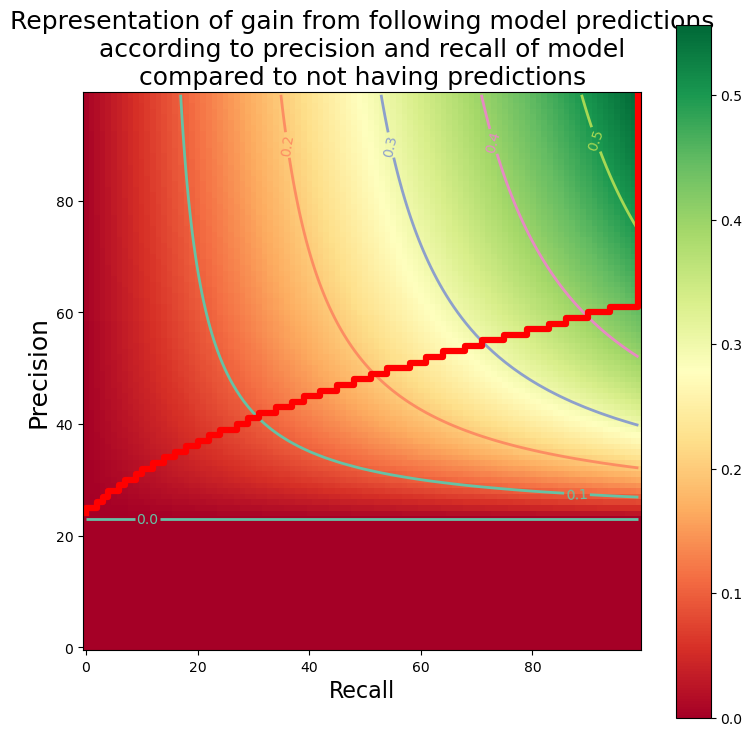

In [6]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show


x = arange(0.01,1.01,0.01)
y = arange(0.01,1.01,0.01)
X,Y = meshgrid(x, y) # grid of point
# print(X)
# print(Y)
Z=X.copy()
for i in range(len(X)):
    for j in range(len(X[0])):
        v=prediction_gain(X[j,i], Y[j,i], verbose=verbose, consider_early_intervention_failure=consider_early_intervention_failure, consider_sanctions=consider_sanctions)
        if v > 0:
            Z[i,j] = v # evaluation of the function on the grid
        else:
            Z[i,j] = 0

O=optimal_line(X, Y, Z)
O=np.array(O)
O=O.transpose(1,0)
Ox=O[0]
Oy=O[1]

# print(O)


fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot()

orig_cmap = plt.get_cmap('RdYlGn') 
im = imshow(Z,cmap=orig_cmap) # drawing the function

# adding the Contour lines with labels
cset = contour(Z,arange(0,1,0.1),linewidths=2,cmap=cm.Set2)
plt.plot(Ox, Oy, 'r-', linewidth=4.5)
if add_paper:
    plt.plot([62], [81], 'go', linewidth=10.5)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
ax.invert_yaxis() # inverting axis to show both axis in increasing manner

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=18)

if consider_early_intervention_failure:
    if consider_sanctions:
        if add_paper:
            title('RF model of Boldt et al. theoretical gain from following\n model predictions according to precision and recall\nvalues with sanctions and with early intervention failure', fontsize=16)
            plt.savefig('gain_cost_formula_w_sanctions_w_earlyintfailure_w_paper.png')
        else:
            title('Representation of gain from following model predictions\naccording to precision and recall of model\ncompared to not having predictions', fontsize=18)
            plt.savefig('gain_cost_formula_w_sanctions_w_earlyintfailure.png')
    else:
        title('Theoretical gain from following model predictions\naccording to precision and recall values\nwithout sanctions and with early intervention failure', fontsize=18)
        plt.savefig('gain_cost_formula_wo_sanctions_w_earlyintfailure.png')
else:
    if consider_sanctions:
        title('Theoretical gain from following model predictions\naccording to precision and recall values\nwith sanctions and without early intervention failure', fontsize=18)
        plt.savefig('gain_cost_formula_w_sanctions_wo_earlyintfailure.png')
    else:
        title('Theoretical gain from following model predictions\naccording to precision and recall values\nwithout sanctions and without early intervention failure', fontsize=18)
        plt.savefig('gain_cost_formula_wo_sanctions_wo_earlyintfailure.png')
show()

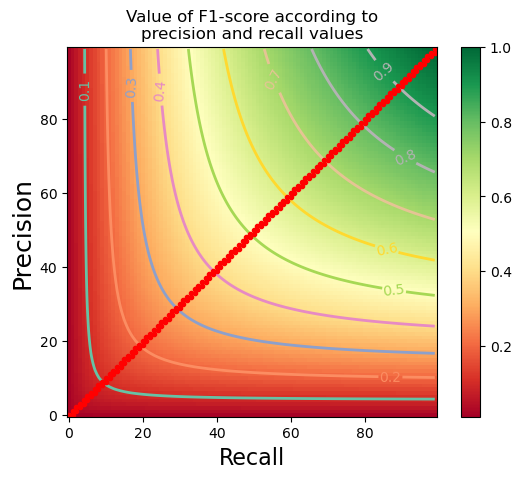

In [7]:
### Showing for F1-score as a comparison
def f1_score(precision, recall):
    return (2*precision*recall)/(precision+recall)


x = arange(0.01,1.01,0.01)
y = arange(0.01,1.01,0.01)
X,Y = meshgrid(x, y) # grid of point
# print(X)
# print(Y)
Z=X.copy()
for i in range(len(X)):
    for j in range(len(X[0])):
        Z[i,j] = f1_score(X[j,i], Y[j,i]) # evaluation of the function on the grid
        
O=optimal_line(X, Y, Z)
O=np.array(O)
O=O.transpose(1,0)
Ox=O[0]
Oy=O[1]


fig = plt.figure()
ax = fig.add_subplot()

orig_cmap = plt.get_cmap('RdYlGn') 
# shrunk_cmap = shiftedColorMap(orig_cmap, start=-16, midpoint=0, stop=1, name='shrunk')
im = imshow(Z,cmap=orig_cmap) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,arange(0,1,0.1),linewidths=2,cmap=cm.Set2)
plt.plot(Ox, Oy, '.r')
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
# cbar = fig.colorbar(im, ticks=[-10, 0, 1])
# cbar.ax.set_yticklabels(['< -10', '0', '> 1'])  # vertically oriented colorbar
# latex fashion title
title('Value of F1-score according to\nprecision and recall values')
ax.invert_yaxis()

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=18)

plt.savefig('gain_cost_formula_f1_score.png')
show()